In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import functools
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torch.utils.data.dataloader as dataloader
import torchvision.models as models
import torchvision.transforms as T
import torch.nn.utils
from torch.autograd import Function
from torch.utils.data import Dataset
from torchvision.io import read_image

In [2]:
#Set device to GPU_indx if GPU is avaliable
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
#device='cpu'

# **Dataloader**
Dataloader for the lung dataset

In [3]:
class lung_dataset(Dataset):
    def __init__(self, data_path, transform, train_test = 'train'):
        self.im_path = data_path + '/images/images/' #Path to images
        self.meta_csv = pd.read_csv(data_path + '/metadata_{}.csv'.format(train_test)) #Path to metadata
        self.transform = transform #Predefined transforms

        #Get dictionaries to map disease classes to numbers and vice versa
        self.label_to_dis_class = self.meta_csv['Finding Labels'].drop_duplicates().reset_index().to_dict()['Finding Labels']
        self.dis_class_to_label = dict((v,k) for k,v in self.label_to_dis_class.items())
        
        #Get dict to map genders to numbers and vice versa
        self.label_to_gender = self.meta_csv['Patient Gender'].drop_duplicates().reset_index().to_dict()['Patient Gender']
        self.gender_to_label = dict((v,k) for k,v in self.label_to_gender.items())

    def __len__(self):
        #return len(self.meta_csv)
        return 500

    def __getitem__(self, idx):
        im_data = self.meta_csv.iloc[idx]

        im = Image.open(self.im_path + im_data['Image Index']).convert("L")
        im = self.transform(im)

        label_dis = self.dis_class_to_label[im_data['Finding Labels']]
        
        label_gen = self.gender_to_label[im_data['Patient Gender']]

        return im, label_dis, label_gen


## Create Datasets/Dataloaders

In [4]:
#train_transform = T.Compose([T.ToTensor()])
train_transform = T.Compose([
        T.Resize(256),
        T.RandomCrop(224),
        #T.RandomHorizontalFlip(),
        T.ToTensor(),
        #normalize
])

#Dataset train_test can be: 'train' or 'test'
#Val data comes from splitting train set
dataset = lung_dataset('./CXR8', train_transform, 'train')

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = dataloader.DataLoader(train_dataset, shuffle = True, batch_size = 8)
test_loader = dataloader.DataLoader(val_dataset, shuffle = False, batch_size = 8)

print(len(dataset))
print(len(train_dataset))
print(len(val_dataset))

500
400
100


## Display output from dataloader

Disease Label: 6  Class:  Atelectasis
Disease Label: 0  Class:  M


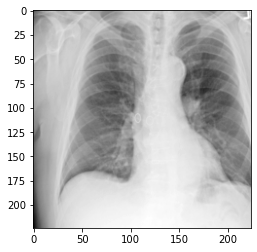

In [5]:
dataiter = iter(train_loader)

images, dis_labels, gen_labels = dataiter.next()

plt.imshow(images[0].permute(1, 2, 0)/255, cmap='gray')
print("Disease Label:", dis_labels[0].item(), " Class: ", dataset.label_to_dis_class[dis_labels[0].item()])
print("Disease Label:", gen_labels[0].item(), " Class: ", dataset.label_to_gender[gen_labels[0].item()])


# **Model**

In [6]:
def get_norm_layer(norm_type='instance'):
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
    elif norm_type == 'none':
        norm_layer = None
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer

In [7]:
class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

## UNet

In [8]:
# with skip connection and pixel connection and smoothed
class UnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, num_downs, ngf=64,
                 norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetGenerator, self).__init__()

        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        use_bias = True
        # construct unet structure
        self.downsample_0 = nn.Conv2d(input_nc, ngf, kernel_size=4, stride=2, padding=1, bias=use_bias)

        self.downRelu_1 = nn.LeakyReLU(0.2, True)
        self.downSample_1 = nn.Conv2d(ngf, ngf * 2, kernel_size=4, stride=2, padding=1, bias=use_bias)
        self.downNorm_1 = norm_layer(ngf * 2)

        self.downRelu_2 = nn.LeakyReLU(0.2, True)
        self.downSample_2 = nn.Conv2d(ngf * 2, ngf * 4, kernel_size=4, stride=2, padding=1, bias=use_bias)
        self.downNorm_2 = norm_layer(ngf * 4)

        self.downRelu_3 = nn.LeakyReLU(0.2, True)
        self.downSample_3 = nn.Conv2d(ngf * 4, ngf * 8, kernel_size=4, stride=2, padding=1, bias=use_bias)
        self.downNorm_3 = norm_layer(ngf * 8)

        self.innerLeakyRelu = nn.LeakyReLU(0.2, True)
        self.innerDownSample = nn.Conv2d(ngf * 8, ngf * 8, kernel_size=4, stride=2, padding=1, bias=use_bias)

        self.innerRelu = nn.ReLU(True)
        innerUpSample = []
        innerUpSample.append(nn.Upsample(scale_factor = 2, mode='bilinear'))
        innerUpSample.append(nn.ReflectionPad2d((2, 1, 2, 1)))
        innerUpSample.append(nn.Conv2d(ngf * 8, ngf * 8, kernel_size=4, stride=1, padding=0, bias=use_bias))
        self.innerUpSample = nn.Sequential(*innerUpSample)

        self.innerNorm = norm_layer(ngf * 8)

        self.upRelu_3 = nn.ReLU(True)
        upSample_3 = []
        upSample_3.append(nn.Upsample(scale_factor = 2, mode='bilinear'))
        upSample_3.append(nn.ReflectionPad2d((2, 1, 2, 1)))
        upSample_3.append(nn.Conv2d(ngf * 16, ngf * 4, kernel_size=4, stride=1, padding=0, bias=use_bias))
        self.upSample_3 = nn.Sequential(*upSample_3)
        self.upNorm_3 = norm_layer(ngf * 4)

        self.upRelu_2 = nn.ReLU(True)
        upSample_2 = []
        upSample_2.append(nn.Upsample(scale_factor = 2, mode='bilinear'))
        upSample_2.append(nn.ReflectionPad2d((2, 1, 2, 1)))
        upSample_2.append(nn.Conv2d(ngf * 8, ngf * 2, kernel_size=4, stride=1, padding=0, bias=use_bias))
        self.upSample_2 = nn.Sequential(*upSample_2)
        self.upNorm_2 = norm_layer(ngf * 2)

        self.upRelu_1 = nn.ReLU(True)
        upSample_1 = []
        upSample_1.append(nn.Upsample(scale_factor = 2, mode='bilinear'))
        upSample_1.append(nn.ReflectionPad2d((2, 1, 2, 1)))
        upSample_1.append(nn.Conv2d(ngf * 4, ngf, kernel_size=4, stride=1, padding=0, bias=use_bias))
        self.upSample_1 = nn.Sequential(*upSample_1)
        self.upNorm_1 = norm_layer(ngf)

        self.upRelu_0 = nn.ReLU(True)
        upSample_0 = []
        upSample_0.append(nn.Upsample(scale_factor = 2, mode='bilinear'))
        upSample_0.append(nn.ReflectionPad2d((2, 1, 2, 1)))
        upSample_0.append(nn.Conv2d(ngf * 2, 1, kernel_size=4, stride=1, padding=0, bias=use_bias))
        self.upSample_0 = nn.Sequential(*upSample_0)

        ## initialize bias
        nn.init.normal_(self.upSample_0[-1].bias, mean=3, std=1)

        self.activation = nn.Sigmoid()

    def forward(self, input):
        # assume input image size = 224
        x_down_0 = self.downsample_0(input) # (ngf, 112, 112)

        x_down_1 = self.downNorm_1(self.downSample_1(self.downRelu_1(x_down_0))) # (ngf*2, 56, 56)
        x_down_2 = self.downNorm_2(self.downSample_2(self.downRelu_2(x_down_1))) # (ngf*4, 28, 28)
        x_down_3 = self.downNorm_3(self.downSample_3(self.downRelu_3(x_down_2))) # (ngf*8, 14, 14)

        latent = self.innerDownSample(self.innerLeakyRelu(x_down_3)) # (ngf*8, 7, 7)

        x = self.innerNorm(self.innerUpSample(self.innerRelu(latent))) # (ngf*8, 14, 14)

        x_up_3 = self.upNorm_3(self.upSample_3(self.upRelu_3(torch.cat([x, x_down_3], 1)))) # (ngf*4, 28, 28)
        x_up_2 = self.upNorm_2(self.upSample_2(self.upRelu_2(torch.cat([x_up_3, x_down_2], 1)))) # (ngf*2, 56, 56)
        x_up_1 = self.upNorm_1(self.upSample_1(self.upRelu_1(torch.cat([x_up_2, x_down_1], 1)))) # (ngf, 112, 112)

        encoded_image = self.activation(self.upSample_0(self.upRelu_0(torch.cat([x_up_1, x_down_0], 1)))) # (3, 224, 224)

        return torch.mul(input, encoded_image), latent

## Resnet gender classifier

In [9]:
class GenderClassification(nn.Module):

    def __init__(self):

        super(GenderClassification, self).__init__()
        print("Build a GenderClassification Model")

        self.base_network = models.resnet18(pretrained = True)
        print('Load weights from Resnet18 done')

        self.finalLayer = nn.Linear(self.base_network.fc.in_features, 2)

    def forward(self, image):
        x = self.base_network.conv1(image)
        x = self.base_network.bn1(x)
        x = self.base_network.relu(x)
        x = self.base_network.maxpool(x)

        x = self.base_network.layer1(x)
        x = self.base_network.layer2(x)
        x = self.base_network.layer3(x)
        x = self.base_network.layer4(x)

        x = self.base_network.avgpool(x)
        image_features = x.view(x.size(0), -1)

        preds = self.finalLayer(image_features)

        return preds

## Resnet lung disease classifier

In [10]:
class LungClassification(nn.Module):
    def __init__(self, output_size):
        super(LungClassification, self).__init__()
        print("Build a LungClassification model")
        
        self.base_network = models.resnet50(pretrained=True)
        print('Load weights from Resnet18/50 done')
        
        self.finalLayer = nn.Linear(self.base_network.fc.in_features, output_size)
        
    def forward(self, image):
        x = self.base_network.conv1(image)
        x = self.base_network.bn1(x)
        x = self.base_network.relu(x)
        conv1_feature = self.base_network.maxpool(x)
        
        layer1_feature = self.base_network.layer1(conv1_feature)
        layer2_feature = self.base_network.layer2(layer1_feature)
        layer3_feature = self.base_network.layer3(layer2_feature)
        layer4_feature = self.base_network.layer4(layer3_feature)
        
        final_feature = self.base_network.avgpool(layer4_feature)
        final_feature = final_feature.view(final_feature.size(0), -1)
        
        preds = self.finalLayer(final_feature)
        
        return preds
        

## Combined complete model

In [11]:
class FullModel(nn.Module):
    def __init__(self, num_object, adv_lambda):
        super(FullModel, self).__init__()
        
        print("Build a FullModel")
        self.num_object = num_object
        self.adv_lambda = adv_lambda
        
        norm_layer = 'batch'
        use_dropout = False
        norm_layer = get_norm_layer(norm_type=norm_layer)
        
        self.autoencoder = UnetGenerator(3, 3, 5, 64, norm_layer=norm_layer, use_dropout=use_dropout)
        
        self.adv_component = GenderClassification()
        
        self.classifier = LungClassification(self.num_object)
        
    def forward(self, image):
        
        autoencoded_image, latent = self.autoencoder(image)
        
        preds = self.classifier(autoencoded_image)
        
        adv_feature = ReverseLayerF.apply(autoencoded_image, self.adv_lambda)
        adv_preds = self.adv_component(adv_feature)
        
        return preds, adv_preds, autoencoded_image
        

# **Test model**

In [12]:
norm_layer = 'batch'
use_dropout = False
norm_layer = get_norm_layer(norm_type=norm_layer)

autoencoder = UnetGenerator(1, 1, 5, 64, norm_layer=norm_layer, use_dropout=use_dropout).to(device)

adv_component = GenderClassification().to(device)

classifier = LungClassification(15).to(device)

out_im_AE, latent = autoencoder(images.to(device))

gend_pred_in = torch.cat((out_im_AE[0],out_im_AE[0],out_im_AE[0]))
gend_pred_in = gend_pred_in.unsqueeze(0)
print(gend_pred_in.size())

class_pred = classifier(gend_pred_in)
print(class_pred)

gend_pred = adv_component(gend_pred_in)
print(gend_pred)

Build a GenderClassification Model
Load weights from Resnet18 done
Build a LungClassification model
Load weights from Resnet18/50 done


C:\Users\jtosk\anaconda3\lib\site-packages\torch\nn\functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
C:\Users\jtosk\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 3, 224, 224])
tensor([[-0.7234, -0.3461, -0.2106,  0.0985, -0.1133, -0.0766,  0.0189,  0.0441,
          0.0222,  0.3367,  0.0424,  0.0943,  0.2994, -0.0291,  0.8014]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 0.9541, -0.0336]], device='cuda:0', grad_fn=<AddmmBackward>)


tensor(0.8862, device='cuda:0', grad_fn=<MaxBackward1>)


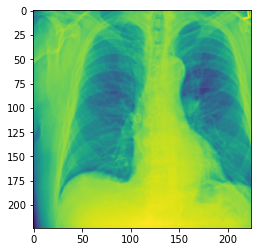

In [13]:
#plt.imshow(images[0].detach().squeeze().numpy())
plt.imshow(out_im_AE[0].cpu().detach().squeeze().numpy())
#plt.show()
print(torch.max(out_im_AE[0]))

Build a FullModel
Build a GenderClassification Model
Load weights from Resnet18 done
Build a LungClassification model
Load weights from Resnet18/50 done

torch.Size([8, 1, 224, 224])
torch.Size([8, 3, 224, 224])

tensor([ 0.3735, -0.1829,  0.1707, -0.1646,  0.0058,  0.0874,  0.3652, -0.0325,
        -0.0570, -0.0676,  0.0989, -0.1909,  0.0998,  0.1597, -0.1131],
       device='cuda:0', grad_fn=<SelectBackward>)
tensor([-0.3216,  0.4791], device='cuda:0', grad_fn=<SelectBackward>)


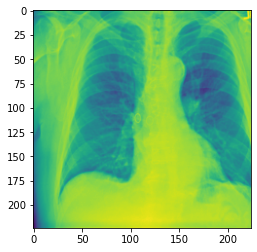

In [14]:
model_testing = FullModel(15, None).to(device)

print('')
print(images.size())

model_input = torch.cat((images, images, images), axis=1)

print(model_input.size())

model_preds, model_adv_preds, model_ae_im = model_testing(model_input.to(device))

print('')
print(model_preds[0])
print(model_adv_preds[0])
plt.imshow(model_ae_im[0][0].cpu().detach().numpy())



# **Training**

In [15]:
model = FullModel(15, 1).to(device)

criterion = nn.CrossEntropyLoss(weight=None, reduction='mean') # Used to have weighting ??
criterionL1 = nn.L1Loss(reduction='mean')
criterion_adv = nn.CrossEntropyLoss(reduction = 'mean')

optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay = 1e-5)

num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('num_trainable_params:', num_trainable_params)

Build a FullModel
Build a GenderClassification Model
Load weights from Resnet18 done
Build a LungClassification model
Load weights from Resnet18/50 done
num_trainable_params: 53935714


In [16]:
l1loss_log = []
taskloss_log = []
advloss_log = []
totalloss_log = []

50it [00:17,  2.92it/s]
50it [00:17,  2.89it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.86it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.86it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.86it/s]
50it [00:17,  2.86it/s]
50it [00:17,  2.86it/s]
50it [00:17,  2.86it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.86it/s]
50it [00:17,  2.87it/s]
50it [00:17,  2.86it/s]
50it [00:17,  2.86it/s]
50it [00:17,  2.

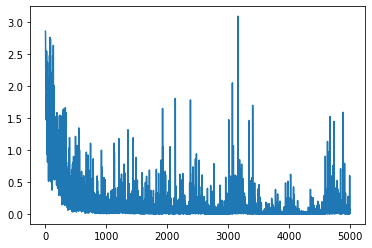

In [20]:
model.train()

for epoch in range(50):
    
    for batch_idx, (im, label_dis, label_gen) in tqdm(enumerate(train_loader)):
        
        im = torch.cat((im, im, im), axis=1)
        images = im.to(device)
        targets = label_dis.to(device)
        genders = label_gen.to(device)
        
        model_preds, model_adv_preds, model_ae_im = model(images)
        
        #breakpoint()
        
        l1_loss = criterionL1(model_ae_im, images)
        task_loss = criterion(model_preds, targets)
        adv_loss = criterion_adv(model_adv_preds, genders)
        
        loss = task_loss #+ adv_loss #+ 1 * l1_loss
        
        l1loss_log.append(l1_loss.item())
        taskloss_log.append(task_loss.item())
        advloss_log.append(adv_loss.item())
        totalloss_log.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
             
plt.plot(totalloss_log)

In [18]:
#plt.plot(l1loss_log)
#plt.plot(taskloss_log)
#plt.plot(advloss_log)
#plt.plot(totalloss_log)

torch.Size([8, 3, 224, 224])


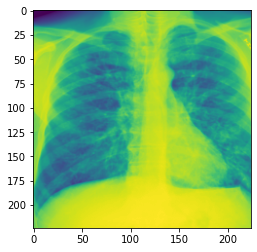

In [21]:
print(model_ae_im.size())
plt.imshow(model_ae_im[0][0].cpu().detach().numpy())